# Multi-state Prediction

In [11]:
import sys
from pathlib import Path

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

# Now you can import modules from the parent directory
import torch
from helpers.simulation import *
from helpers.models import *
from tqdm import tqdm
import matplotlib.pyplot as plt

## Window-based prediction on single-state pretrained model

In [12]:
# Define model run type
multimodal = True
use_sum=True
cross_attn_base = True
cross_attn_complex = True
hierarchy_model = False
disp_model = False

# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model type
if multimodal:
    if cross_attn_base:
        if cross_attn_complex:
            model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                model_props['num_layers'], model_props['dropout'], output_dim=output_size)
        else:
            model = CrossAttentionModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                model_props['num_layers'], model_props['dropout'])
    elif hierarchy_model:
        # Model using a hierarchical (one-stream to two-streams)
        model = HierarchicalModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
            model_props['num_layers'], model_props['dropout'])
    else:
        # Model using simply sum or concat of modalities
        model = DiffusionTensorRegModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                model_props['num_layers'], model_props['dropout'], use_sum=use_sum)
    print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
else:
    if not disp_model:
        model = DiffusionTensorRegModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                model_props['num_layers'], model_props['dropout'])
        print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    else:
        model = DisplacementBasedModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                model_props['num_layers'], model_props['dropout'])
        print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cuda
Total params of CrossAttentionModel: 917093


In [13]:
# Load pretrained model
model_path = '../results/model_06_11_2025.pt'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()

CrossAttentionModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_siz

### Create data for evaluation

In [17]:
# Image parameters
N = 2000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 9,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": 100, #  -1 for no noise,
    "gaussian_noise": True,
    "trajectory_unit" : 1200,
    "D_min": 6, # >= 1
    "D_max": 10,
    "angle_max": np.pi,
    "D_max_norm": 10, # factor to divide by for normalization
}

all_videos, all_displacements, og_labels = create_multi_state_dataset_w_features(N, T, image_props)

### Evaluate

In [ ]:
# Settings for window-based prediction
WINDOW_SIZE = 25

# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Reshape labels into frames
all_labels = all_labels.reshape(N, nFrames//WINDOW_SIZE, -1, 3).mean(axis=2) # shape: (N, total_windows, 3)

# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)
all_displacements = torch.Tensor(all_displacements)

# Create dataset and dataloader objects
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

batch_loss = []
errors = []

# Get predictions for one sample to plot
plot_preds = []
with torch.no_grad():
    for idx, (videos, displacements, labels) in enumerate(dataloader):
        videos = videos.to(device)
        displacements = displacements.to(device)
        labels = labels.to(device)

        window_loss = []

        # Make predictions for each window
        for window_idx, frame in enumerate(range(0, nFrames, WINDOW_SIZE)):
            end = frame + WINDOW_SIZE if frame + WINDOW_SIZE <= nFrames else nFrames
            val_predictions = model(videos[:,frame:end], displacements[:,frame:end])
            
            window_label = labels[:, window_idx]
            l = model_props['loss_fn'](window_label, val_predictions)
            window_loss.append(l.item())

            angle_pred = 0.5 * torch.atan2(val_predictions[:,2], val_predictions[:,3])
            if model_props['loss_fn'] is mse_loss or mse_loss_coeff:
                mae = (val_predictions[:,:-2] - window_label[:,:-1]).abs().mean(axis=0)
            else:
                mae = (torch.exp(val_predictions[:,:-2]) - window_label[:,:-1]).abs().mean(axis=0)

            angle_sim = torch.abs(torch.cos(angle_pred - window_label[:,-1])).mean().unsqueeze(-1)
            errors.append(torch.cat([
                    mae.cpu() * D_max_normalization,
                    angle_sim.cpu()
                ], dim=0))
            
            if idx == 0:
                plot_preds.append(val_predictions[0].cpu())

        batch_loss.append(np.mean(window_loss))

plot_preds = torch.stack(plot_preds, dim=0).numpy() * np.array([D_max_normalization, D_max_normalization, 1, 1])

print(f"Average loss across validation set: {np.mean(batch_loss)}")
print(f"MAE of diffusion coefficients and angle simularity across validation set: {np.mean(errors, axis=0)}")

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
print(plot_preds.shape, og_labels.shape)

(4, 4) (2000, 100, 3)


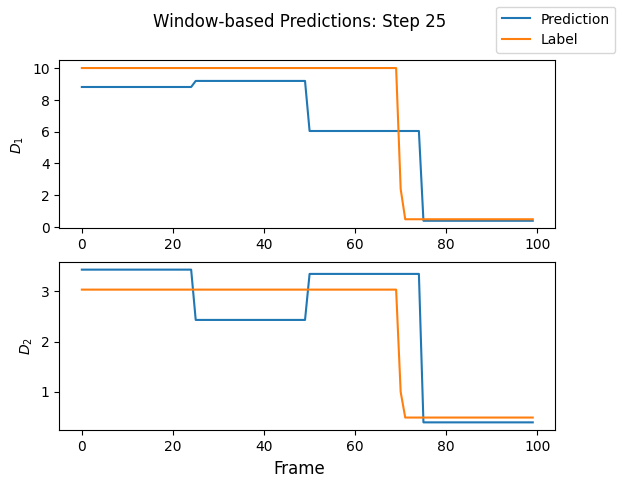

In [ ]:
# Plot predictions and labels across frames
fig, (ax1,ax2) = plt.subplots(2,1)

# Repeat labels to get back original shape of simulation
preds = np.tile(plot_preds[:, None, :], (1, WINDOW_SIZE, 1)).reshape(-1,4)
pred_D1 = preds[:,0]
pred_D2 = preds[:,1]
label_D1 = og_labels[0,:,0]
label_D2 = og_labels[0,:,1]

ax1.plot(pred_D1, label='Prediction')
ax1.plot(label_D1, label='Label')
ax2.plot(pred_D2)
ax2.plot(label_D2)
fig.suptitle(f'Window-based Predictions: Step {WINDOW_SIZE}')
ax1.set_ylabel(r'$D_{1}$')
ax2.set_ylabel(r'$D_{2}$')
fig.supxlabel('Frame')

fig.legend()
plt.show()

In [ ]:
# Settings for window-based prediction
WINDOW_SIZE = 30

# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)
all_displacements = torch.Tensor(all_displacements)

# Create dataset and dataloader objects
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

batch_loss = []
errors = []

# Get predictions for one sample to plot
plot_preds = []
with torch.no_grad():
    for idx, (videos, displacements, labels) in enumerate(dataloader):
        videos = videos.to(device)
        displacements = displacements.to(device)
        labels = labels.to(device)

        window_loss = []

        # Make predictions for each window
        for frame in range(nFrames-WINDOW_SIZE+1):
            end = frame + WINDOW_SIZE if frame + WINDOW_SIZE <= nFrames else nFrames
            val_predictions = model(videos[:,frame:end], displacements[:,frame:end])
            
            window_label = labels[:, frame:end].mean(dim=1)
            l = model_props['loss_fn'](window_label, val_predictions)
            window_loss.append(l.item())

            angle_pred = 0.5 * torch.atan2(val_predictions[:,2], val_predictions[:,3])
            if model_props['loss_fn'] is mse_loss or mse_loss_coeff:
                mae = (val_predictions[:,:-2] - window_label[:,:-1]).abs().mean(axis=0)
            else:
                mae = (torch.exp(val_predictions[:,:-2]) - window_label[:,:-1]).abs().mean(axis=0)

            angle_sim = torch.abs(torch.cos(angle_pred - window_label[:,-1])).mean().unsqueeze(-1)
            errors.append(torch.cat([
                    mae.cpu() * D_max_normalization,
                    angle_sim.cpu()
                ], dim=0))
            
            if idx == 0:
                plot_preds.append(val_predictions[0].cpu())

        batch_loss.append(np.mean(window_loss))

plot_preds = torch.stack(plot_preds, dim=0).numpy() * np.array([D_max_normalization, D_max_normalization, 1, 1])

print(f"Average loss across validation set: {np.mean(batch_loss)}")
print(f"MAE of diffusion coefficients and angle simularity across validation set: {np.mean(errors, axis=0)}")  

Average loss across validation set: 1.4515709179046918
MAE of diffusion coefficients and angle simularity across validation set: [0.78196716 0.5099961  0.74562424]


In [ ]:
print(plot_preds.shape, og_labels.shape)

(71, 4) (2000, 100, 3)


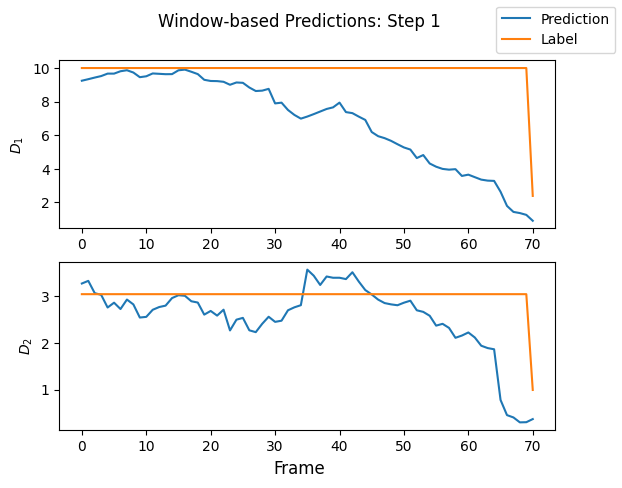

In [ ]:
# Plot predictions and labels across frames
fig, (ax1,ax2) = plt.subplots(2,1)

# Repeat labels to get back original shape of simulation
pred_D1 = plot_preds[:,0]
pred_D2 = plot_preds[:,1]
label_D1 = all_labels[0,:plot_preds.shape[0],0] * D_max_normalization
label_D2 = all_labels[0,:plot_preds.shape[0],1] * D_max_normalization

ax1.plot(pred_D1, label='Prediction')
ax1.plot(label_D1, label='Label')
ax2.plot(pred_D2)
ax2.plot(label_D2)
fig.suptitle('Window-based Predictions: Step 1')
ax1.set_ylabel(r'$D_{1}$')
ax2.set_ylabel(r'$D_{2}$')
fig.supxlabel('Frame')

fig.legend()
plt.show()

## Point-based Prediction

In [18]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.2,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": True,
    "use_segment_embed": True
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MultiStateModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
            model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
            use_segment_embed=model_props['use_segment_embed'])
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cuda
Total params of MultiStateModel: 925284


In [19]:
# Load pretrained model
model_path = '../results/multi_state_model_11_11_2025.pt'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()

MultiStateModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3

In [20]:
# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)
all_displacements = torch.Tensor(all_displacements)

# Create dataset and dataloader objects
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

batch_loss = []
errors = []

# Get predictions for one sample to plot
plot_preds = []
with torch.no_grad():
    for idx, (videos, displacements, labels) in enumerate(dataloader):
        videos = videos.to(device)
        displacements = displacements.to(device)
        labels = labels.to(device)

        val_predictions = model(videos, displacements)
        val_loss = model_props['loss_fn'](labels, val_predictions)
        batch_loss.append(val_loss.item()) # batch loss

        angle_pred = 0.5 * torch.atan2(val_predictions[...,2], val_predictions[...,3])

        mae = (val_predictions[...,:-2] - labels[...,:-1]).abs().mean(dim=((0,1) if labels.dim()==3 else 0))

        angle_sim = torch.abs(torch.cos(angle_pred - labels[...,-1])).mean().unsqueeze(-1)
        errors.append(torch.cat([
                mae.cpu() * D_max_normalization,
                angle_sim.cpu()
            ], dim=0))
        
        if idx == 0:
            plot_preds.append(val_predictions[0].cpu())


plot_preds = plot_preds[0].numpy() * np.array([D_max_normalization, D_max_normalization, 1, 1])

print(f"Average loss across validation set: {np.mean(batch_loss)}")
print(f"MAE of diffusion coefficients and angle simularity across validation set: {np.mean(errors, axis=0)}")  

Average loss across validation set: 0.5655729696154594
MAE of diffusion coefficients and angle simularity across validation set: [0.89281285 0.6705861  0.9078465 ]


In [21]:
print(plot_preds.shape)

(30, 4)


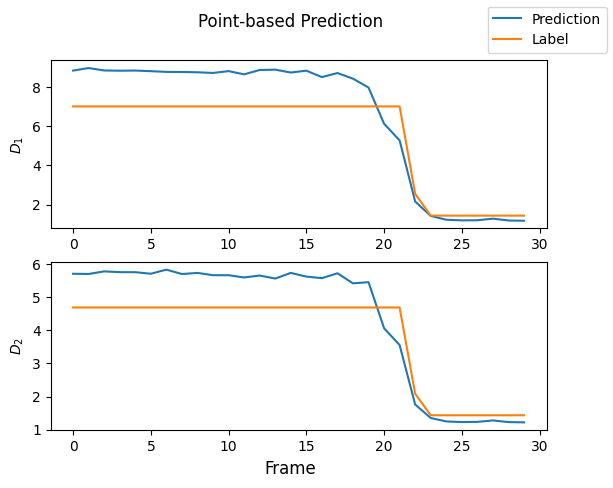

In [22]:
# Plot predictions and labels across frames
fig, (ax1,ax2) = plt.subplots(2,1)

pred_D1 = plot_preds[:,0]
pred_D2 = plot_preds[:,1]
label_D1 = all_labels[0,:,0] * D_max_normalization
label_D2 = all_labels[0,:,1] * D_max_normalization

ax1.plot(pred_D1, label='Prediction')
ax1.plot(label_D1, label='Label')
ax2.plot(pred_D2)
ax2.plot(label_D2)
fig.suptitle('Point-based Prediction')
ax1.set_ylabel(r'$D_{1}$')
ax2.set_ylabel(r'$D_{2}$')
fig.supxlabel('Frame')

fig.legend()
plt.show()